In [1]:
%pip install xlrd
%pip install openpyxl
%pip install seaborn

In [61]:
import pandas as pd

file_path = 'En_In.xls'
data = pd.read_excel(file_path, skiprows=2)

data = data.iloc[:, 2:]

data.columns = ['Country', 'Energy Supply', 'Energy Supply per Capita', '% Renewable']

In [3]:
import numpy as np

data['Energy Supply'] = pd.to_numeric(data['Energy Supply'], errors='coerce') * 1e6

In [4]:
country_replacements = {
    "Republic of Korea": "South Korea",
    "United States of America": "United States",
    "United Kingdom of Great Britain and Northern Ireland19": "United Kingdom",
    "China, Hong Kong Special Administrative Region": "Hong Kong"
}

data['Country'] = data['Country'].replace(country_replacements)

In [5]:
data['Country'] = data['Country'].str.replace(r'\s*\(.*?\)', '', regex=True)
data['Country'] = data['Country'].str.replace(r'\d+', '', regex=True)
data['Country'] = data['Country'].str.strip()

In [6]:
data.loc[data['Country'].isin(['American Samoa', 'South Korea', 'Bolivia'])]

,Country,Energy Supply,Energy Supply per Capita,% Renewable
18,American Samoa,NaN,...,0.641026
39,Bolivia,3.360000e+08,32,31.47712
179,South Korea,1.100700e+10,221,2.279353


In [7]:
gdp_file_path = 'gpd.csv'

gdp_data = pd.read_csv(gdp_file_path, skiprows=4)

columns = ['Country', 'Country Code', 'Indicator Name', 'Indicator Code'] + [str(year) for year in range(1960, 2016)]
gdp_data.columns = columns

country_replacements_gdp = {
    "Korea, Rep.": "South Korea",
    "Iran, Islamic Rep.": "Iran",
    "Hong Kong SAR, China": "Hong Kong"
}
gdp_data['Country'] = gdp_data['Country'].replace(country_replacements_gdp)

In [8]:
gdp_data.head(1)

,Country,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,Aruba,ABW,GDP at market prices (constant 2010 US$),NY.GDP.MKTP.KD,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.467704e+09,NaN,NaN,NaN,NaN,NaN


In [9]:
scimago_file_path = 'scimagojr.xlsx'
scimago_data = pd.read_excel(scimago_file_path, sheet_name='Sheet1')

country_replacements_scimago = {
    "United States of America": "United States",
    "United Kingdom": "United Kingdom"
}
scimago_data['Country'] = scimago_data['Country'].replace(country_replacements_scimago)

scimago_top15 = scimago_data.head(15)
scimago_top15 = scimago_top15.set_index('Country')

data['Country'] = data['Country'].replace(country_replacements_scimago)
data = data.set_index('Country')

gdp_last_10_years = gdp_data[['Country'] + [str(year) for year in range(2006, 2016)]]
gdp_last_10_years = gdp_last_10_years.set_index('Country')

common_countries = scimago_top15.index.intersection(gdp_last_10_years.index).intersection(data.index)

result = pd.merge(scimago_top15.loc[common_countries], gdp_last_10_years.loc[common_countries], left_index=True, right_index=True)
result = pd.merge(result, data.loc[common_countries], left_index=True, right_index=True)

In [10]:
result.head(3)

,Rank,Documents,Citable documents,Citations,Self-citations,Citations per document,H index,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,Energy Supply,Energy Supply per Capita,% Renewable
Country,,,,,,,,,,,,,,,,,,,,
China,1,127050,126767,597237,411683,4.70,138,3.992331e+12,4.559041e+12,4.997775e+12,5.459247e+12,6.039659e+12,6.612490e+12,7.124978e+12,7.672448e+12,8.230121e+12,8.797999e+12,1.271910e+11,93,19.75491
United States,2,96661,94747,792274,265436,8.20,230,1.479230e+13,1.505540e+13,1.501149e+13,1.459484e+13,1.496437e+13,1.520402e+13,1.554216e+13,1.577367e+13,1.615662e+13,1.654857e+13,9.083800e+10,286,11.57098
Japan,3,30504,30287,223024,61554,7.31,134,5.496542e+12,5.617036e+12,5.558527e+12,5.251308e+12,5.498718e+12,5.473738e+12,5.569102e+12,5.644659e+12,5.642884e+12,5.669563e+12,1.898400e+10,149,10.23282


In [11]:
result.shape

(15, 20)

In [12]:
def average_gdp_top15():
    years = [str(year) for year in range(2006, 2016)]
    
    gdp_years = gdp_last_10_years[years]
    
    avg_gdp = gdp_years.mean(axis=1)
    
    avg_gdp = avg_gdp.dropna()
    
    avg_gdp_filtered = avg_gdp[avg_gdp.index.isin(scimago_top15.index)]
    
    avg_gdp_sorted = avg_gdp_filtered.sort_values(ascending=False)
    
    return avg_gdp_sorted.head(15)

In [13]:
average_gdp_top15()

Country
United States         1.536434e+13
China                 6.348609e+12
Japan                 5.542208e+12
Germany               3.493025e+12
France                2.681725e+12
United Kingdom        2.487907e+12
Brazil                2.189794e+12
Italy                 2.120175e+12
India                 1.769297e+12
Canada                1.660647e+12
Russian Federation    1.565459e+12
Spain                 1.418078e+12
Australia             1.164043e+12
South Korea           1.106715e+12
Iran                  4.441558e+11
dtype: float64

In [14]:
def gdp_change_fifth_country():
    avg_gdp_sorted = average_gdp_top15()
    
    fifth_country = avg_gdp_sorted.index[4]
    
    gdp_values = gdp_last_10_years.loc[fifth_country]
    gdp_change = gdp_values.iloc[-1] - gdp_values.iloc[0]
    
    return (fifth_country, gdp_change)

In [15]:
gdp_change_fifth_country()

('France', 153345695364.24023)

In [17]:
def max_renewable_energy(df):
    max_renewable = df['% Renewable'].idxmax()
    max_value = df.loc[max_renewable, '% Renewable']
    return (max_renewable, max_value)

In [18]:
max_renewable_energy(result)

('Brazil', 69.64803)

In [20]:
def sixth_largest_population(df):
    df['Estimated Population'] = df['Energy Supply'] / df['Energy Supply per Capita']
    sorted_df = df.sort_values('Estimated Population', ascending=False)
    sixth_country = sorted_df.iloc[5]
    return (sixth_country.name, sixth_country['Estimated Population'])

In [22]:
sixth_largest_population(result)

('Japan', 127409395.97315437)

In [23]:
def calculate_correlation(df):
    df['Estimated Population'] = df['Energy Supply'] / df['Energy Supply per Capita']

    df['Citations per Person'] = df['Citations'] / df['Estimated Population']
    
    correlation = df['Citations per Person'].corr(df['Energy Supply per Capita'])
    
    return correlation

In [24]:
calculate_correlation(result)

0.6668248468590926

In [25]:
def renewable_energy_indicator(df):
    median_value = df['% Renewable'].median()

    df['Renewable Indicator'] = (df['% Renewable'] >= median_value).astype(int)
    
    return df.sort_values(by='Rank')['Renewable Indicator']

In [27]:
renewable_energy_indicator(result)

Country
China                 1
United States         0
Japan                 0
United Kingdom        0
Russian Federation    1
Canada                1
Germany               1
India                 0
France                1
South Korea           0
Italy                 1
Spain                 1
Iran                  0
Australia             0
Brazil                1
Name: Renewable Indicator, dtype: int32

In [28]:
def continent_population_stats(df, continent_dict):
    df['Continent'] = df.index.map(continent_dict)

    df['Population Estimate'] = df['Energy Supply'] / df['Energy Supply per Capita']

    stats = df.groupby('Continent')['Population Estimate'].agg(['size', 'sum', 'mean', 'std'])
    
    return stats

In [29]:
ContinentDict = {
    'China': 'Asia',
    'United States': 'North America',
    'Japan': 'Asia',
    'United Kingdom': 'Europe',
    'Russian Federation': 'Europe',
    'Canada': 'North America',
    'Germany': 'Europe',
    'India': 'Asia',
    'France': 'Europe',
    'South Korea': 'Asia',
    'Italy': 'Europe',
    'Spain': 'Europe',
    'Iran': 'Asia',
    'Australia': 'Australia',
    'Brazil': 'South America'
}

continent_population_stats(result, ContinentDict)

,size,sum,mean,std
Continent,,,,
Asia,5,2898666386.6106,579733277.32212,6.790979e+08
Australia,1,23316017.316017,23316017.316017,NaN
Europe,6,457929667.216372,76321611.202729,3.464767e+07
North America,2,352855249.48025,176427624.740125,1.996696e+08
South America,1,205915254.237288,205915254.237288,NaN


In [59]:
import matplotlib.pyplot as plt

def chart(df, continent_dict):
    df['Continent'] = df.index.map(lambda country: continent_dict.get(country, 'Other'))

    sizes = df['2015'] / 1e9 

    colors = df['Continent'].map({
        'Asia': 'red', 
        'North America': 'blue', 
        'Europe': 'green', 
        'South America': 'orange', 
        'Australia': 'yellow', 
        'Other': 'gray'
    })

    plt.figure(figsize=(20, 8))
    scatter = plt.scatter(
        df['Rank'], df['% Renewable'], 
        s=sizes, 
        c=colors, 
        alpha=0.6, 
        edgecolors="w", 
        linewidth=0.5
    )

    for i in range(len(df)):
        plt.text(df['Rank'].iloc[i], df['% Renewable'].iloc[i], df.index[i], fontsize=9, ha='center')

    plt.legend(
        handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in ['red', 'green', 'blue', 'yellow', 'orange', 'gray']],
        labels=['Asia', 'North America', 'Europe', 'South America', 'Australia', 'Other'],
        title="Continent", loc="upper left"
    )

    plt.title('% Renewable vs Rank')
    plt.xlabel('Rank')
    plt.ylabel('% Renewable')
    plt.show()


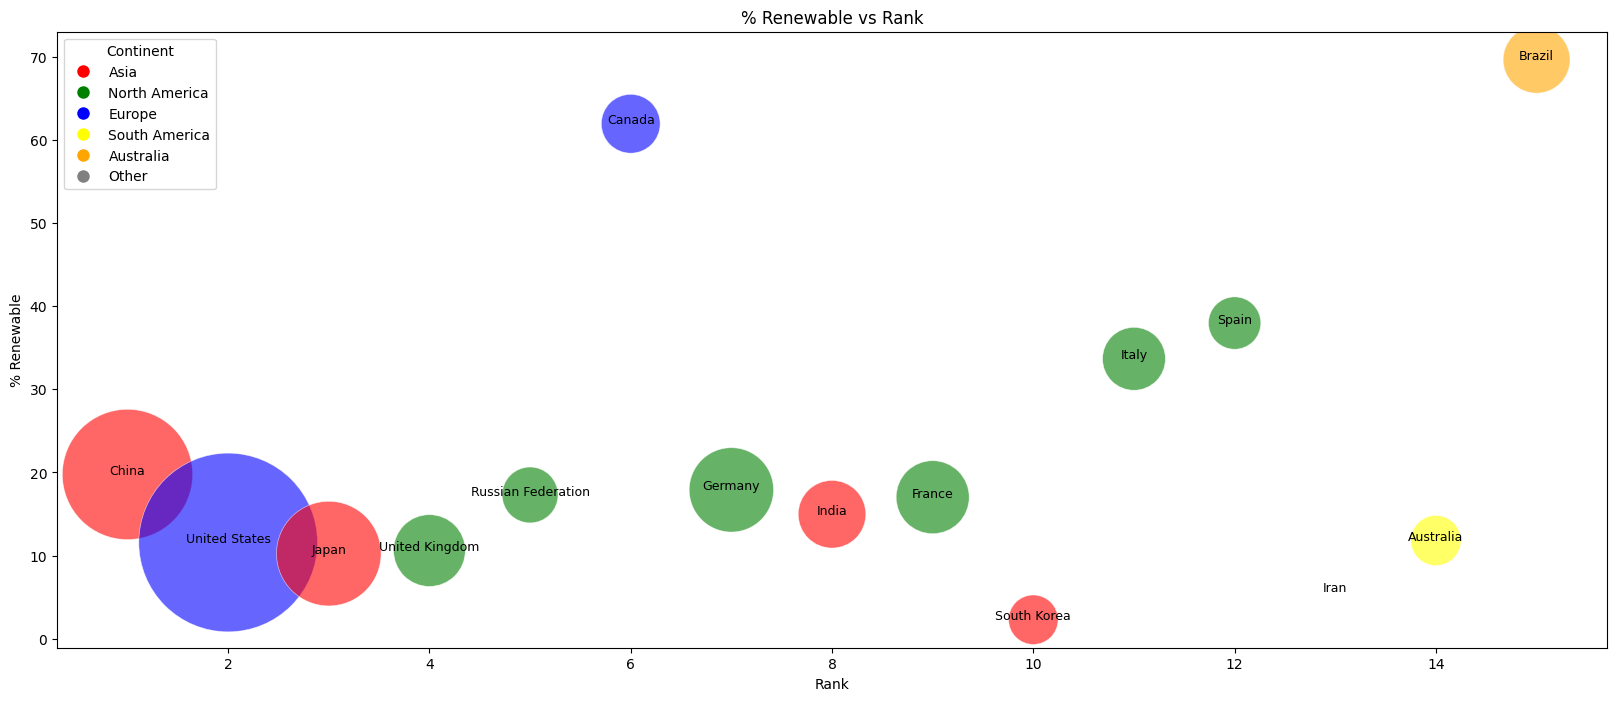

In [60]:
chart(result, ContinentDict)